In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing
from scipy.stats import iqr
import tensorflow as tf
import math

# Pre processing

In [2]:
path = '/anomalyvol/data/jet_ver/bb1_ae_input.h5'

In [3]:
chunk_size = 100000
total_size = 1000000 # 1 mil max

def generator(path, chunk_size=10000,total_size=1000000):
    i = 0
    
    while True:
        yield pd.read_hdf(path,start=i*chunk_size, stop=(i+1)*chunk_size)
        
        i+=1
        if (i+1)*chunk_size > total_size:
            i=0

gen = generator(path, chunk_size, total_size)

In [4]:
data = next(gen)

for i in range(total_size // chunk_size - 1):
    data.append(next(gen))

In [67]:
# loaded_data = data
data = loaded_data

In [68]:
loaded_data

,px,py,pz,e,pt,eta,phi,mass,event
0,1200.201700,714.940197,-1176.756007,1834.490410,1397.005228,-0.765391,0.537239,1.702256e+02,0
1,-1240.890636,-526.559303,306.056940,1446.853969,1347.988973,0.225140,-2.740281,4.273655e+02,0
2,20.740248,-187.983284,54.143463,212.832236,189.123962,0.282513,-1.460910,8.122914e+01,0
3,-52.327745,5.439510,-379.791004,383.564394,52.609706,-2.674631,3.038014,1.061396e+01,0
4,11.816352,-4.110155,3.456675,13.912894,12.510777,0.272896,-0.334746,5.010037e+00,0
...,...,...,...,...,...,...,...,...,...
99995,0.459043,0.283232,-4.613422,4.644847,0.539389,-2.842835,0.552829,4.280033e-08,7762
99996,-872.915359,2163.768770,1624.944659,2844.911643,2333.211630,0.649749,1.954251,9.591975e+01,7763
99997,224.008143,-1080.661553,277.581281,1153.309031,1103.634468,0.248937,-1.366403,1.872467e+02,7763
99998,818.611150,-567.764479,1043.302421,1455.156678,996.233265,0.914391,-0.606398,1.911028e+02,7763


In [69]:
data = np.array(data)
data = data[:,:4]  # just keep px, py, pz, e
data.shape

(100000, 4)

In [7]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [8]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [9]:
# get the inverse iqr proportion for each feature used to scale their weights in the loss function
iqr_prop = iqr(x_train,axis = 0)
max_iqr = max(iqr_prop)
iqr_prop = np.array(iqr_prop) / max_iqr
print(iqr_prop)

[0.01960501 0.01973707 0.22276554 1.        ]


# VAE Model

In [10]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape, LeakyReLU, ELU
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [11]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 2
input_dim = 4

In [13]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
encoding = Dense(latent_dim, activation='tanh')(h3)

In [14]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(encoding)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [15]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [16]:
mse = keras.losses.MeanSquaredError()
def ae_loss(x, y):
    mse_loss = 0.25 * (iqr_prop[0]*(x[::,0] - y[::,0])**2 + iqr_prop[1]*(x[::,1] - y[::,1])**2 + iqr_prop[2]*(x[::,2] - y[::,2])**2 + iqr_prop[3]*(x[::,3] - y[::,3])**2)
    # mse_loss = mse(x,y)
    return mse_loss

vae.compile(optimizer='adam', loss=ae_loss)

In [17]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144     

# Train

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
batch_size = 1000
epochs = 200

In [20]:
x_train.shape

(80000, 4)

In [21]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [22]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 80000 samples, validate on 10000 samples
Epoch 1/200
80000/80000 [==============================] - 1s 14us/step - loss: 0.2247 - val_loss: 0.1091
Epoch 2/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0674 - val_loss: 0.0370
Epoch 3/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0253 - val_loss: 0.0167
Epoch 4/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0149 - val_loss: 0.0131
Epoch 5/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0126 - val_loss: 0.0120
Epoch 6/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0117 - val_loss: 0.0115
Epoch 7/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0113 - val_loss: 0.0113
Epoch 8/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0110 - val_loss: 0.0110
Epoch 9/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0108 - val_loss: 0.0110
Epoc

Epoch 78/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 79/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 80/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 81/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 82/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 83/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 84/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 85/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 86/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 87/200
80000/80000 [====================

80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 155/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 156/200
80000/80000 [==============================] - 0s 5us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 157/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0099 - val_loss: 0.0102
Epoch 158/200
80000/80000 [==============================] - 0s 6us/step - loss: 0.0099 - val_loss: 0.0102


# Visualization

In [23]:
import matplotlib.pyplot as plt

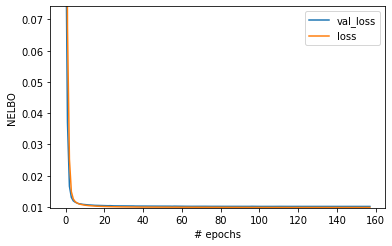

In [24]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [25]:
predictions = vae.predict(x_test)

In [26]:
# mse on test set
p = vae.predict(x_train)
print(mse(p, x_train))

tf.Tensor(0.49919707, shape=(), dtype=float32)


In [27]:
distr = (x_test - predictions) / x_test

In [28]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [29]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

In [30]:
overall_distr = K.flatten(distr)
overall_pred = K.flatten(predictions)
overall_input = K.flatten(x_test)

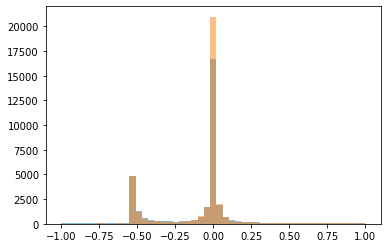

In [31]:
# overall pred vs input
bins = np.linspace(-1, 1, 50)
plt.hist(overall_input, bins=bins,alpha=0.5)
plt.hist(overall_pred, bins=bins,alpha=0.5)
plt.show()

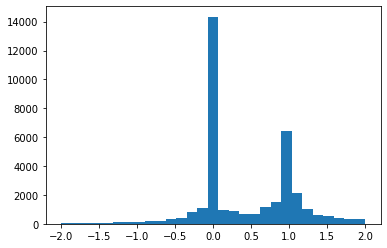

In [32]:
# overall distr
bins = np.linspace(-2, 2, 30)
plt.hist(overall_distr, bins=bins)
plt.show()

## Stacking output (orange) over input (blue) for px, py, pz, E

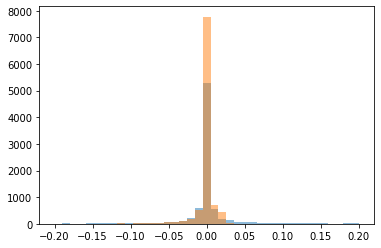

In [33]:
# px
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)
plt.show()

In [34]:
print(mse(px,px_pred))

tf.Tensor(0.98558974, shape=(), dtype=float32)


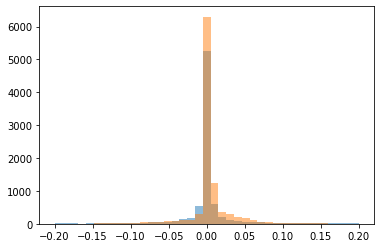

In [35]:
# py
bins = np.linspace(-0.2, 0.2, 40)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)
plt.show()

In [36]:
print(mse(py,py_pred))

tf.Tensor(1.0381765, shape=(), dtype=float32)


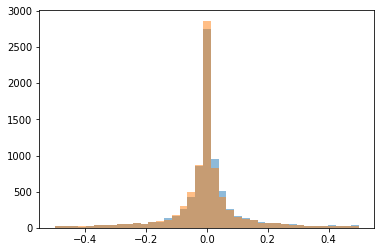

In [37]:
# pz
bins = np.linspace(-0.5, 0.5, 40)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)
plt.show()

In [38]:
print(mse(pz,pz_pred))

tf.Tensor(0.00033471655, shape=(), dtype=float32)


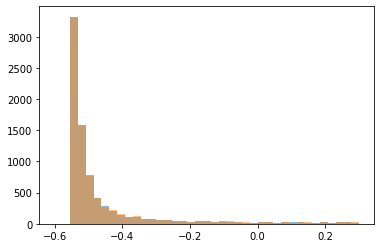

In [39]:
# E
bins = np.linspace(-0.6,0.3, 40)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)
plt.show()

In [40]:
print(mse(e,e_pred))

tf.Tensor(7.875856e-05, shape=(), dtype=float32)


In [41]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [42]:
bins = np.linspace(-2, 2, 30)

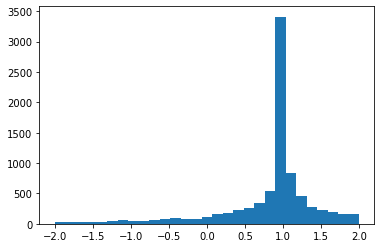

In [43]:
_ = plt.hist(d_px, bins=bins)

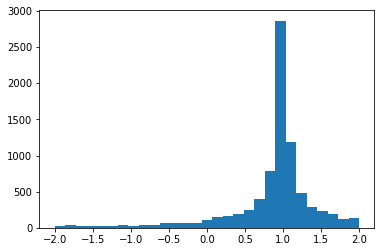

In [44]:
_ = plt.hist(d_py, bins=bins)

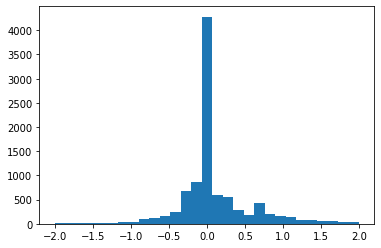

In [45]:
_ = plt.hist(d_pz, bins=bins)

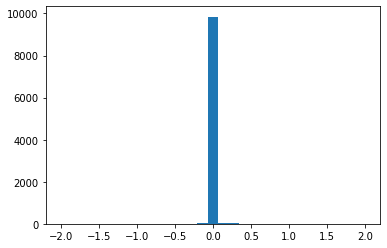

In [46]:
_ = plt.hist(d_e, bins=bins)

# Anomaly Detection

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
# m_12 = sqrt ( (E_1 + E_2)^2 - (p_x1 + p_x2)^2 - (p_y1 + p_y2)^2 - (p_z1 + p_z2)^2 )
def invariant_mass(jet1, jet2):
    return math.sqrt((jet1.e + jet2.e)**2 - (jet1.px + jet2.px)**2 - (jet1.py + jet2.py)**2 - (jet1.pz + jet2.pz)**2)

In [49]:
all_data = np.concatenate((x_train, x_val, x_test))
all_pred = vae.predict(all_data)

In [50]:
# get the iqr weighted mse of all predictions
errors = (iqr_prop[0] * np.square(all_data[:,0] - all_pred[:,0]) + iqr_prop[1] * np.square(all_data[:,1] - all_pred[:,1]) + iqr_prop[2] * np.square(all_data[:,2] - all_pred[:,2]) + iqr_prop[3] * np.square(all_data[:,3] - all_pred[:,3]))

In [51]:
# all the inputs that had high mse
data_df = loaded_data.copy()
data_df.columns = ['px','py','pz','e','pt','eta','phi','mass','event']
data_df["mse"] = errors

In [52]:
mass_mu = data_df.mass.mean()
mass_sd = data_df.mass.std()

In [53]:
cut = 0.95
data_df["outlier"] = 0
# define the outliers by a cut on mse error
mse_thresh = np.quantile(errors, cut)
data_df.loc[data_df["mse"] > mse_thresh, "outlier"] = 1
outliers = data_df.loc[data_df.outlier == 1]

In [54]:
mass = []
for event, group in outliers.groupby(['event']):
    pseudojets_input = np.zeros(len(group), dtype=DTYPE_PTEPM)
    for i in range(len(group.pt.array)):
        pseudojets_input[i]['pT'] = group.pt.array[i]
        pseudojets_input[i]['eta'] = group.eta.array[i]
        pseudojets_input[i]['phi'] = group.phi.array[i]
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    if(len(jets) >= 2):
        mass.append(invariant_mass(jets[0],jets[1]))

In [55]:
path = '/anomalyvol/data/jet_ver/bb1_jet_mass.h5'
mgen = generator(path, chunk_size, total_size)
all_mass = next(mgen)

for i in range(total_size // chunk_size - 1):
    all_mass.append(next(mgen))

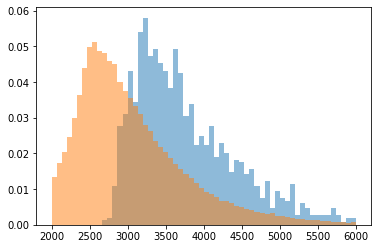

In [72]:
weights = np.ones_like(mass) / len(mass)
plt.hist(mass, bins=np.linspace(2000,6000, 61), alpha = 0.5, weights=weights)
weights = np.ones_like(all_mass) / len(all_mass)
plt.hist(all_mass.mass, bins=np.linspace(2000,6000, 61), alpha = 0.5, weights=weights)
plt.show()